# COMP47590: Advanced Machine Learning
# Assignment 1: Implementing Perceptrons

- Student 1 Name: Carl Fabian Winkler
- Student 1 Number: 20207528
- Student 2 Name: David Moreno Boras
- Student 2 Number: 0815

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.base import BaseEstimator, ClassifierMixin

"""
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample"""

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import train_test_split\n\nfrom sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state\nfrom sklearn.utils.multiclass import unique_labels\nfrom sklearn import preprocessing\nfrom sklearn import metrics\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.utils import resample'

## Task 1: The Perceptron Classifier

Define the PerceptronClassifier class

In [2]:
class Layer():
    def __init__(self, n_in, n_out, activation = 'Sigmoid', init = 'Xavier'):
        self.activation = activation
        # XW + b = y ; We input more than one sample per pass...
        
        self.weights = np.zeros((n_in, n_out))
        self.biases = np.zeros((n_out))
        if init == 'Xavier':
            var = np.sqrt(6.0 / (n_in + n_out))
            for i in range(n_in):
                for j in range(n_out):
                      self.weights[i,j] = np.float32(np.random.uniform(-var, var))
        print(self.weights) 
        
    def forward(self, x):
        z = x @ self.weights + self.biases
        
        if self.activation == 'Sigmoid':
            out = 1 / (1 + np.exp(-z))
        elif self.activation == 'ReLu':
            out = np.maximum(z, 0)
        elif self.activation == 'TanH':
            out = np.tanh(z)
        else:
            out = z
        
        self.cache = (x, z)
        
        return out    
    
    def backward(self, d_out):
        inputs, z = self.cache
        weight = self.weights
        bias = self.biases
        
        if self.activation == 'Sigmoid':
            d_act = d_out * (1 / (1 + np.exp(-z))) * (1 - 1 / (1 + np.exp(-z)))
        elif self.activation == 'ReLu':
            d_act = d_out * (z > 0)
            
        elif self.activation == 'TanH':
            d_act = d_out * np.square(z)
        else:
            d_act = z
            
        d_inputs = d_act @ weight.T
        d_weight = inputs.T @ d_act
        d_bias = d_act.sum(axis=0) 
        
        self.d_w = d_weight
        self.d_b = d_bias
        
        return d_inputs, d_weight, d_bias
    
    def update_gd_params(self, lr):
        self.weights = self.weights - lr * self.d_w
        self.biases = self.biases - lr * self.d_b

class PerceptronClassifier(BaseEstimator, ClassifierMixin):
    
    """
    Parameters
    ----------
    Attributes
    ----------
    Notes
    -----
    See also
    --------
    Examples
    --------
    """
    # Constructor for the classifier object
    def __init__(self, in_dim, out_dim, hidden_units, layers, 
                 learning_rate = 0.01, weight_decay = 0, epochs = -1):

        """Setup a Perceptron classifier .
        Parameters
        ----------
        Returns
        -------
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        
    
    # The fit function to train a classifier
    def fit(self, X, y):
        # WRITE CODE HERE
        
        return
    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        # WRITE CODE HERE
        return
    # The predict_proba function to make a set of predictions for a set of query instances. This returns a set of class distributions.
    def predict_proba(self, X):
        # WRITE CODE HERE
        return

## Task 2: Evaluation

Load the Diabethic Retinopathy dataset

In [3]:
x = np.array([[1,1],[2,2]])


D = 2
N = 2
H = 1


weights = np.ones((2,1))
biases = np.ones((1))  
              


In [4]:
lay = Layer(2,1)
x = np.ones((1,2))
y = np.ones((1,1))



[[0.06820958]
 [0.85438317]]


In [12]:
outpur = []

for i in range(500):
    out = lay.forward(x)
    #print("out: ", out)
    d_inputs, d_weight, d_bias = lay.backward(-y-out)
    #print("Weight grad:", d_weight)
    lay.update_gd_params(0.1)
    outpur.append(np.squeeze(out))

Evaluate the perfomrance of the perceptron classifier on the daibetic retinopathy dataset.

In [ ]:

np.squeeze(out)[0]

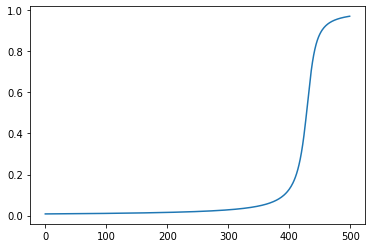

In [13]:
plt.plot(outpur)

## Task 3 & 4: Add Different Activations & Regularisation

Reimplement the PerceptronClassifier class adding an activation function option and L2 regularisation. 

In [ ]:
class PerceptronClassifier2(BaseEstimator, ClassifierMixin):
    """
    """
    # Constructor for the classifier object
    def __init__(self):

        """Setup a Perceptron classifier .
        Parameters
        ----------

        
        Returns
        -------

        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels

        
    # The fit function to train a classifier
    def fit(self, X, y):
        
        # WRITE CODE HERE
        

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):

        # WRITE CODE HERE
    
    # The predict_proba function to make a set of predictions for a set of query instances. This returns a set of class distributions.
    def predict_proba(self, X):
        
        # WRITE CODE HERE

Load the dataset and explore it.

## Task 5: Reflect on the Performance of the Different Models Evaluated

Perform hyper-parameter tuning and evaluate models. 

## Test the Diabetic Retiniphaty dataset

In [11]:
diabetic_af = pd.read_csv('messidor_features.csv', na_values='?', index_col = 0)
diabetic_af.head()
y = diabetic_af.pop('Class').values
x_raw = diabetic_af.values
print("Features: ", x_raw[0:2])
print("Class: ", y[0:10])

Features:  [[1.0000000e+00 2.2000000e+01 2.2000000e+01 2.2000000e+01 1.9000000e+01
  1.8000000e+01 1.4000000e+01 4.9895756e+01 1.7775994e+01 5.2709200e+00
  7.7176100e-01 1.8632000e-02 6.8640000e-03 3.9230000e-03 3.9230000e-03
  4.8690300e-01 1.0002500e-01 1.0000000e+00]
 [1.0000000e+00 2.4000000e+01 2.4000000e+01 2.2000000e+01 1.8000000e+01
  1.6000000e+01 1.3000000e+01 5.7709936e+01 2.3799994e+01 3.3254230e+00
  2.3418500e-01 3.9030000e-03 3.9030000e-03 3.9030000e-03 3.9030000e-03
  5.2090800e-01 1.4441400e-01 0.0000000e+00]]
Class:  ["b'0'" "b'0'" "b'1'" "b'0'" "b'1'" "b'1'" "b'1'" "b'0'" "b'1'" "b'1'"]


### Train and predict using our classifier

With a single split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_raw, y, shuffle=True, train_size = 0.7)
clf = PerceptronClassifier()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(y_pred, y_test)

### Grid search

Do grid search with the train set, use the test set for evaluation

In [ ]:
cv_folds = 5
param_grid ={'activation': ['Sigmoid', 'ReLu', 'TanH'], 'regularisation':['None', 'L2']}

# Perform the search
tuned_perceptron = GridSearchCV(PerceptronClassifier(), \
                            param_grid, cv=cv_folds, verbose = 2, \
                            n_jobs = -1)
cross_val_score(clf, x_train, y_train, cv=10)